Generate training data using function for dx/dt

In [1]:
import torch
import torch.nn as nn
import numpy as np

# Define the ODE
def dxdt_eval(x):
    dxdt = -x**3
    return dxdt


In [2]:
import pyomo.environ as pyo
from omlt.neuralnet import FullSpaceNNFormulation, ReluComplementarityFormulation
import pyomo.dae as dae
import torch.nn as nn

# Define the Pyomo model
m = pyo.ConcreteModel()

# Define a range of times to solve
t0 = 0
tend = 1
m.t = dae.ContinuousSet(bounds=(t0, tend))

# Define variables
m.x = pyo.Var(m.t)
m.x0 = pyo.Var(initialize=3)
m.dxdt = dae.DerivativeVar(m.x, wrt=m.t)

# Define the target for x at tend
x_target = 0.5

# Define initial condition constraint
def init_condition(m):
    return m.x[t0] == m.x0
m.init_condition = pyo.Constraint(rule=init_condition)

# Connect m.dxdt to nn output
def connect_output(m, t):
    return m.dxdt[t] == dxdt_eval((m.x[t]))
m.outputs = pyo.Constraint(m.t, rule=connect_output)

# Discretize wrt time to approximate x(t)
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=20, ncp=3, scheme='LAGRANGE-RADAU')

# Define the objective
def objective_rule(m):
    return (x_target - m.x[tend])**2
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
results = solver.solve(m, tee=True)
solution = pyo.value(m.x0)

print(solution)


'_BlockData'. The class '_BlockData' has been renamed to 'BlockData'.
(deprecated in 6.7.2) (called from c:\Users\Jake\CondaJun24\Lib\site-
packages\omlt\block.py:33)
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      424
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables

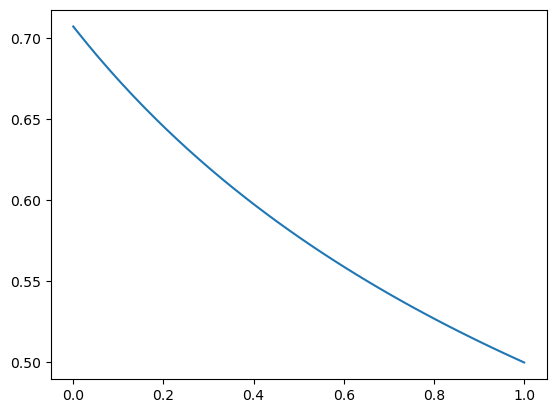

In [3]:
import matplotlib.pyplot as plt
tplot = []
xplot = []
for t in m.t:
    tplot.append(t)
    xplot.append(pyo.value(m.x[t]))


plt.figure()
plt.plot(tplot, xplot)
plt.show()
